In [2]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtype

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import layers, models, optimizers, losses, callbacks,\
                             regularizers


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import csv file

text_file = pd.read_csv('/content/drive/MyDrive/Project/spam_or_not_spam.csv')
text_file


,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0
...,...,...
2995,abc s good morning america ranks it the NUMBE...,1
2996,hyperlink hyperlink hyperlink let mortgage le...,1
2997,thank you for shopping with us gifts for all ...,1
2998,the famous ebay marketing e course learn to s...,1


In [4]:
# Define a regular expression pattern to match non-text characters
#non_text_pattern = '[^a-zA-Z0-9\s]+'  # This pattern matches any character that is not a letter (a-zA-Z) or numbers (0-9) or whitespace (\s)

# Apply the pattern to remove non-text characters from the 'email' column
#text_file['email'] = text_file['email'].str.replace(non_text_pattern, '', regex=True)

# Now, the 'email' column should contain only letters and spaces
#text_file

In [6]:
# Check for null values

text_file[text_file['email'].isna()]

,email,label
2966,NaN,1


In [7]:
# Drop null values

text_file = text_file.dropna(subset=['email'])
text_file

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0
...,...,...
2995,abc s good morning america ranks it the NUMBE...,1
2996,hyperlink hyperlink hyperlink let mortgage le...,1
2997,thank you for shopping with us gifts for all ...,1
2998,the famous ebay marketing e course learn to s...,1


In [8]:
# Confirm that null vales have been dropped

text_file[text_file['email'].isna()]

,email,label


In [9]:
# Carry out a cursory view of the dataset

text_file.groupby('label').describe()

email                                                               
      count unique                                                top freq
label                                                                     
0      2500   2445                     url URL date not supplied URL    10
1       499    427  lowest rates available for term life insurance...    5

In [10]:
# Check target class distribution

text_file['label'].value_counts()

0    2500
1     499
Name: label, dtype: int64

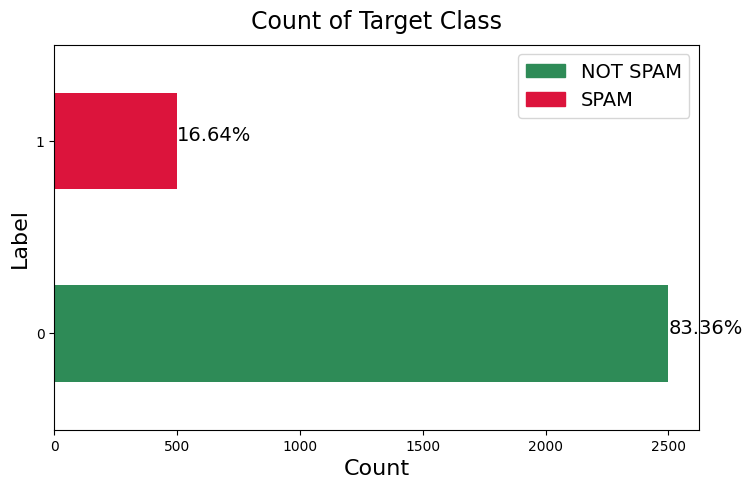

In [11]:
# Compute the value counts of the target variable
target_label = text_file['label'].value_counts()

# Set the figure size
plt.figure(figsize=(6, 5))

# Define the colors for the bars and legend
bar_colors = ['seagreen', 'crimson']
legend_colors = bar_colors[:len(target_label)]

# Plot the count plot with different bar colors
plt.subplots_adjust(right=1.2)
ax = target_label.plot(kind='barh', color=bar_colors)
plt.xlabel("Count", size=16)
plt.ylabel("Label", size=16)

# Add percentage count labels to each bar
total = target_label.sum()
for i, count in enumerate(target_label):
    percentage = f'{(count / total) * 100:.2f}%'
    ax.text(count, i, f"{percentage}", size=14)

# Create custom legend
legend_labels = ['NOT SPAM', 'SPAM']
legend_patches = [mpatches.Patch(color=color,
                                 label=label) for color,
                  label in zip(legend_colors, legend_labels)]
plt.legend(handles=legend_patches, fontsize=14)

plt.title("Count of Target Class", y=1.02, size=17)
# Display the plot
plt.show()

#OPTION 1 DOWN-SAMPLING

In [12]:
# Create a new dataframe for the spam class

text_file_spam = text_file[text_file['label']==1]
text_file_spam.shape

(499, 2)

In [13]:
# Create a new dataframe for the not-spam class

text_file_not_spam = text_file[text_file['label']==0]
text_file_not_spam.shape

(2500, 2)

In [14]:
# Exract random samples from the non-spam dataset to give an equal count as the spam dataset
dwns_not_spam = text_file_not_spam.sample(text_file_spam.shape[0])
dwns_not_spam.shape

(499, 2)

In [15]:
# Merge the two dataframes to create a new down-sampled dataset
dwns_text_file = pd.concat([text_file_spam, dwns_not_spam])
dwns_text_file

,email,label
2500,save up to NUMBER on life insurance why spend...,1
2501,NUMBER fight the risk of cancer URL NUMBER sli...,1
2502,NUMBER fight the risk of cancer URL NUMBER sli...,1
2503,adult club offers free membership instant acc...,1
2504,i thought you might like these NUMBER slim dow...,1
...,...,...
1760,use perl daily headline mailer damian conway p...,0
2413,url URL date NUMBER NUMBER NUMBERtNUMBER NUMBE...,0
16,in forteana y d mcmann dmcmann b wrote robert...,0
346,gary lawrence murphy if we had more variety of...,0


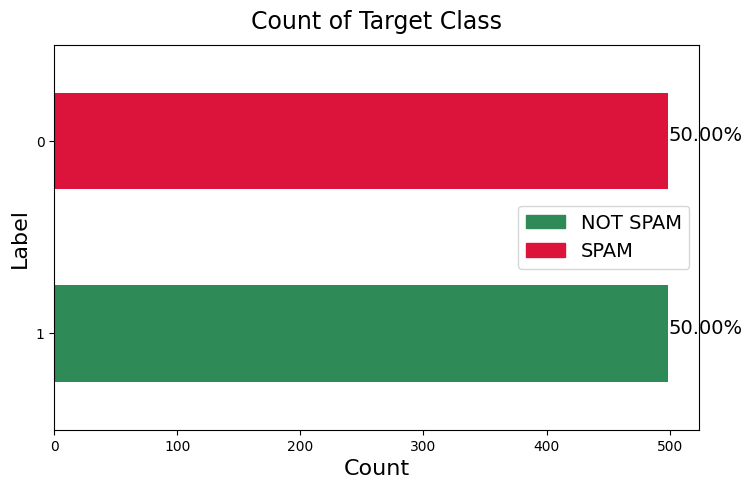

In [16]:
# Compute the value counts of the target variable in the new dataset
target_label = dwns_text_file['label'].value_counts()

# Set the figure size
plt.figure(figsize=(6, 5))

# Define the colors for the bars and legend
bar_colors = ['seagreen', 'crimson']
legend_colors = bar_colors[:len(target_label)]

# Plot the count plot with different bar colors
plt.subplots_adjust(right=1.2)
ax = target_label.plot(kind='barh', color=bar_colors)
plt.xlabel("Count", size=16)
plt.ylabel("Label", size=16)

# Add percentage count labels to each bar
total = target_label.sum()
for i, count in enumerate(target_label):
    percentage = f'{(count / total) * 100:.2f}%'
    ax.text(count, i, f"{percentage}", size=14)

# Create custom legend
legend_labels = ['NOT SPAM', 'SPAM']
legend_patches = [mpatches.Patch(color=color,
                                 label=label) for color,
                  label in zip(legend_colors, legend_labels)]
plt.legend(handles=legend_patches, fontsize=14)

plt.title("Count of Target Class", y=1.02, size=17)
# Display the plot
plt.show()

# Build the Models

In [17]:
# Split the dataset into training and test sets

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dwns_text_file['email'], dwns_text_file['label'], test_size=0.3, stratify=dwns_text_file['label'])
x_train.head(5)

631     advice to the lovelorn haiku serendipity pilot...
2887    professional effective debt collection service...
419     glad they finally figured this one out note th...
2407    url URL date not supplied img URL dynamic html...
2766    attn i am edward mulete jr the son of mr steve...
Name: email, dtype: object

In [18]:
# Import BERT models

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [30]:
# Build neural network layers

# Bert layers
input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(input)
bert_output = bert_encoder(preprocessed_text)

# Neural network functional layers
#layer_1 = tf.keras.layers.Dropout(0.1, name="dropout")(bert_output['pooled_output'])
#layer_2 = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer_1)

x = tf.keras.layers.Dense(128, activation='relu', name='dense_layer')(bert_output['pooled_output'])
x = tf.keras.layers.Dropout(0.3, name='dropout_layer')(x)
x = tf.keras.layers.Dense(64, activation='relu', name='dense_layer_2')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout_layer_2')(x)

# Output layer
output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

# Create the model
model = models.Model(inputs=[input], outputs=[output])

# Print the model summary
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                              

In [31]:
### Compile the model using the adam optimizer, with default learning rate,
### binary Crossentropy, and an array of metrics.

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [32]:
# Train the model

model.fit(x_train, y_train, epochs=20)

Epoch 1/20
22/22 [==============================] - 13s 453ms/step - loss: 0.7319 - accuracy: 0.5630 - precision: 0.5647 - recall: 0.5501
Epoch 2/20
22/22 [==============================] - 8s 366ms/step - loss: 0.6792 - accuracy: 0.5745 - precision: 0.5734 - recall: 0.5817
Epoch 3/20
22/22 [==============================] - 10s 449ms/step - loss: 0.6430 - accuracy: 0.6318 - precision: 0.6285 - recall: 0.6447
Epoch 4/20
22/22 [==============================] - 8s 364ms/step - loss: 0.6106 - accuracy: 0.6691 - precision: 0.6821 - recall: 0.6332
Epoch 5/20
22/22 [==============================] - 10s 442ms/step - loss: 0.5874 - accuracy: 0.7092 - precision: 0.7340 - recall: 0.6562
Epoch 6/20
22/22 [==============================] - 8s 369ms/step - loss: 0.5203 - accuracy: 0.7751 - precision: 0.8019 - recall: 0.7307
Epoch 7/20
22/22 [==============================] - 11s 487ms/step - loss: 0.4753 - accuracy: 0.7951 - precision: 0.7994 - recall: 0.7880
Epoch 8/20
22/22 [===================

In [34]:
#Evaluate the performance of the model

model.evaluate(x_test, y_test)

10/10 [==============================] - 5s 297ms/step - loss: 0.2561 - accuracy: 0.9133 - precision: 0.9026 - recall: 0.9267


[0.2561472952365875,
 0.9133333563804626,
 0.9025974273681641,
 0.9266666769981384]

In [35]:
# Make predictions using the trained model

y_predicted = model.predict(x_test)

# Convert the predicted values into a 1D array
y_predicted = y_predicted.flatten()

10/10 [==============================] - 4s 317ms/step


In [36]:
# Introduce thresholds such that any value greater than 0.5 becomes casted as 1
# and any less than 0.5 becomes casted as 0

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1])

In [37]:


from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[135,  15],
       [ 11, 139]])

In [43]:
# Creating a dataframe for the Confusion matrix

cm_df = pd.DataFrame(cm, index = ['NOT SPAM','SPAM'],
                     columns = ['NOT SPAM','SPAM'])
cm_df

,NOT SPAM,SPAM
NOT SPAM,135,15
SPAM,11,139


Text(0.5, 14.722222222222216, 'Predicted Values')

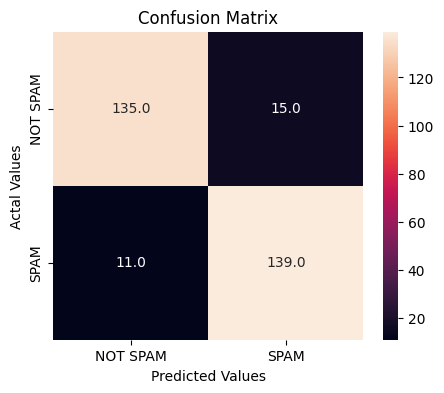

In [44]:
#Plotting the confusion matrix

import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='.1f')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
#plt.show()

In [45]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       150
           1       0.90      0.93      0.91       150

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300

